# Project 4 (Capstone Project): Analyzing COVID 19 Pandemic (ICU Prediction)
*Predicting ICU Admission for COVID-19 Patients (CRISP-DM Workflow)*


## 1. Business Understanding
This section defines the clinical and operational motivation for the project. It explains why predicting ICU admission for COVID-19 patients matters in a real hospital setting, how such predictions can support resource planning and patient triage, and what success looks like from both a healthcare and machine-learning perspective. Establishing this context ensures that all subsequent analysis aligns with meaningful, real-world objectives.


### 1.1 Problem Statement
During the COVID-19 pandemic, hospitals in Brazil and worldwide faced severe pressure on ICU capacity. ICU beds, staff and equipment are limited, and a surge of critical patients can quickly overwhelm the system. Clinicians need support to identify, as early as possible, which newly admitted COVID-19 patients are likely to require intensive care.


### 1.2 Project Objectives
The goal of this project is to build a machine learning model that predicts whether a confirmed COVID-19 patient will be admitted to the ICU during their hospital stay, using clinical information available shortly after admission. This can help hospitals:
- Prioritize high-risk patients for closer monitoring,
- Plan ICU bed allocation in advance,
- Support decisions about patient transfer to higher-complexity centers.

### 1.3 Success Criteria

From a data-science perspective:
- F1 score ≥ target
- Achieve a strong **F1-score** on a held-out test set (balancing precision and recall).
- Avoid data leakage by using only information available **before** ICU admission.
- Provide interpretable insights into which clinical features are associated with ICU admission.

From a clinical/operational perspective:
- The model should flag high-risk patients early enough (e.g. using the first time window) to be actionable.
- The false-negative rate (missed ICU cases) should be low enough to be acceptable in a triage context.

## 2. Data Understanding
The goal of this section is to develop a clear understanding of the dataset before any transformation or modeling occurs. This includes examining dataset structure, feature types, time-window behavior, class balance, and potential sources of data leakage. By establishing a solid understanding of the raw data, we ensure that subsequent EDA, preprocessing, and model development steps are grounded in accurate assumptions and methodological rigor.


### 2.1 Dataset Description

This dataset comes from Hospital Sírio-Libanês in Brazil and contains anonymized clinical measurements from confirmed COVID-19 patients. Each record represents a patient encounter aggregated into one of several predefined time windows following hospital admission.

The dataset includes demographic information, comorbidity indicators, blood laboratory results, vital signs, and blood gas measurements. Many features are expanded into summary statistics such as mean, median, max, min, difference, and relative difference. All numeric features were pre-scaled using a MinMax transformation to the range [-1, 1].

The target variable `ICU` indicates whether the patient required intensive care unit admission. The goal of the project is to develop a predictive model that can identify patients likely to require ICU support early in their hospitalization.


### 2.2 Load the Dataset
Load the dataset into memory so we can inspect its structure and begin understanding its contents. Ensures that the file is read correctly and that the dataframe is ready for exploration.


In [29]:
# load necessary libraries ...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style
sns.set_theme(style="whitegrid")

# Load dataset (update path if needed)
df = pd.read_excel("./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
df.head(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


### 2.3 Inspect Structure
Examine the dataset’s basic structure, feature types, missing values, and overall dimensions. This step provides an initial understanding of data quality, potential issues, and readiness for deeper analysis.


In [30]:
# Basic information about the dataset
df.info()
df.describe()
df.isnull().sum()

# Shape of the dataset (rows, columns)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


(1925, 231)

#### Interpretation of Dataset Structure

The dataset contains 1,925 rows and 231 columns. Most columns are continuous clinical measurements already scaled between -1 and 1, with a small number of identifier or categorical fields.  

A large number of features per patient encounter is typical in clinical datasets, especially when laboratory values are expanded into summary statistics (mean, median, max, min, diff, relative diff).  

No obvious structural issues (e.g., malformed columns or inconsistent dtypes) were observed.  
This confirms that the dataset is clean and ready for exploratory analysis.


#### 2.3.1 Inspect Time Window and Target Variables

In addition to basic dataset structure, it is important to understand:
- how many samples exist in each time window (`WINDOW`), and  
- the class distribution of the target variable (`ICU`).

This helps assess class imbalance and confirms the temporal structure of the dataset.


In [31]:
# Inspect distribution of time windows
df['WINDOW'].value_counts().sort_index()

WINDOW
0-2         385
2-4         385
4-6         385
6-12        385
ABOVE_12    385
Name: count, dtype: int64

#### Interpretation of Time Window Distribution

Each of the five clinical time windows (0–2h, 2–4h, 4–6h, 6–12h, and 12+ hours) contains exactly 385 observations.  
This balanced distribution confirms that the dataset was intentionally constructed so each patient-time window is equally represented.

Because ICU admission could occur at any point during hospitalization, using measurements from windows **at or after** the ICU event could introduce data leakage.  
This will be addressed during the cohort selection and Data Preparation steps.


#### 2.3.2 Examine ICU Class Distribution
The target variable `ICU` indicates whether a patient was admitted to the ICU.
Understanding the frequency and balance of this variable is critical before modeling.


ICU Counts:
 ICU
0    1410
1     515
Name: count, dtype: int64

ICU Percentages:
 ICU
0    73.246753
1    26.753247
Name: proportion, dtype: float64


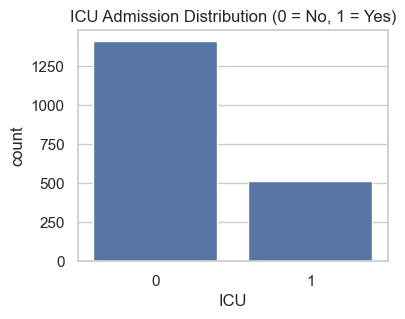

In [32]:
# Check ICU target class distribution
icu_counts  = df['ICU'].value_counts()
icu_percent = df['ICU'].value_counts(normalize=True) * 100

print("ICU Counts:\n", icu_counts)
print("\nICU Percentages:\n", icu_percent)

# Simple bar plot for target balance
plt.figure(figsize=(4,3))
sns.countplot(x='ICU', data=df)
plt.title('ICU Admission Distribution (0 = No, 1 = Yes)')
plt.show()


##### Interpretation of ICU Class Balance

The target variable is imbalanced, with approximately 27% ICU admissions and 73% non-ICU cases.  
This imbalance is moderate and typical in clinical prediction problems.

As a result, accuracy alone is not a reliable performance metric.  
We will emphasize **F1-score**, **precision**, **recall**, and confusion-matrix–based interpretation when evaluating model performance.  

During modeling, we may also consider techniques such as:
- class_weight adjustments  
- balanced random forests  
- or oversampling methods (e.g., SMOTE)

depending on baseline model performance.


### 2.4 Initial Observations
Summarize early impressions of the dataset based on its structure and metadata. Highlights key characteristics that influence later modeling decisions.

- The dataset contains **~1,900 patient–window records** with over **200 clinical features**, including demographics, comorbidities, blood tests, vital signs, and blood gases.
- The **ICU** column is a binary target indicating whether the patient was admitted to the ICU (1) or not (0). The classes are imbalanced, with fewer ICU admissions than non-ICU cases.
- The **WINDOW** column encodes time since hospital admission in 5 discrete windows (0–2h, 2–4h, 4–6h, 6–12h, 12+ hours). Each patient may appear in multiple windows.
- According to the dataset description, features were already **scaled using a Min-Max scaler to the range [-1, 1]**, so no additional global scaling is required unless new features are engineered.
- In later steps we must ensure that only measurements **before ICU admission** are used as model inputs to avoid temporal data leakage.
- Overall, the dataset appears structurally sound and ready for further exploratory data analysis.


### 2.5 Target Variable Analysis
Understand the distribution and characteristics of the target variable `ICU`, as this directly affects modeling strategy, evaluation metrics, and class imbalance considerations.

The target variable `ICU` represents whether the patient was admitted to intensive care (1) or not (0).  
As shown earlier in Section 2.3.2, the distribution is moderately imbalanced, with approximately 27% positive cases.  
This imbalance affects evaluation strategy: metrics such as **F1-score**, **precision**, and **recall** will be emphasized over accuracy during model assessment.


### 2.6 Windows & Cohort Selection
Define how time windows will be handled to avoid temporal leakage and to construct a clinically valid modeling cohort. This step provides the conceptual foundation for selecting which rows of data are appropriate for training.


#### 2.6.1 Understanding Time Windows
Each patient encounter is represented across several predefined time windows relative to hospital admission:
- Each row corresponds to a patient-time window: \
  0–2h, 2–4h, 4–6h, 6–12h, 12+ hours after hospital admission.
- ICU admission may occur at any time window.
- Clinical relevance: Earlier windows (0–2) are the most valuable for prediction.

#### 2.6.2 Identifying Windows Containing or Occurring After ICU Admission
Measurements recorded during or after ICU admission may reflect the patient’s deteriorating condition rather than predictors of deterioration.  
Using such data would introduce temporal leakage and invalidate the model.

Because the dataset does not explicitly indicate the exact window in which ICU admission occurs, a conservative approach is required.  
To guarantee temporal validity, the modeling process will use only windows that clearly occur **before** any potential ICU admission event.


#### 2.6.3 Selecting the Training Cohort

There are two valid modeling strategies:


##### Strategy A: EARLY-ONLY MODEL
Use only the 0–2 hour window for prediction.
- Clinically relevant
- Faster modeling
- Less leakage risk
- Useful for emergency triage


##### Strategy B: MULTI-WINDOW MODEL (but only pre-ICU windows)

Use all windows before ICU admission.
- More data
- Possibly better F1 score
- Must be careful about correlated repeated measures

For this project, we will pick one strategy during Data Preparation.
(Bootcamp-friendly → Strategy A is simple, clean, defensible.)


#### 2.6.4 Decision Rationale (to be completed after EDA)
*A brief narrative will be added here after exploratory analysis, explaining the final choice of cohort strategy (early-only vs. multi-window).*


## 3. Exploratory Data Analysis (EDA)
The goal of this section is to explore the dataset visually and statistically to identify patterns, distribution properties, and potential predictive signals. EDA also helps validate assumptions made during Data Understanding and guides which modeling strategies are most appropriate.


In [33]:
# placeholder ...


### 3.1 Univariate Analysis
The purpose of this subsection is to understand the distribution of key continuous clinical features. Since the dataset contains more than 200 features, a representative subset is selected to avoid excessive output while still providing meaningful insights.

- Histograms (continuous features)
- Bar plots (categorical features)
- Identify skew, outliers


In [34]:
# NOTE: Identify available clinical measurement summary features. Many 
# laboratory and vital sign variables in this dataset are expanded into 
# summary statistics (e.g., MEAN, MIN, MAX). Before selecting features for 
# exploratory analysis, we list all columns ending with these suffixes to 
# verify which measurements are consistently present across the dataset. 
# This helps ensure we choose valid, non-missing feature names for univariate 
# and bivariate EDA without trial-and-error.

# Get columns ending with '_MEAN'
#[col for col in df.columns if col.endswith('_MEAN')]

# Get columns ending with '_MIN'
#[col for col in df.columns if col.endswith('_MIN')]

# Get columns ending with '_MAX'
#[col for col in df.columns if col.endswith('_MAX')]


The selected features form a clinically meaningful and diverse subset of continuous variables that represent several physiological systems. They also exist consistently across all patient-window records, making them reliable for early exploratory analysis.

- **AGE_PERCENTIL**  
  Age is one of the strongest predictors of COVID-19 severity and ICU admission risk. Using age in percentile format already incorporates demographic scaling across the population.

- **HEART_RATE_MEAN**  
  Heart rate is a core vital sign and often increases in response to infection, fever, oxygen decline, or systemic stress — all relevant for identifying early ICU risk.

- **RESPIRATORY_RATE_MEAN**  
  COVID-19 primarily impacts respiratory function. Respiratory rate is one of the earliest and most sensitive indicators of respiratory distress and worsening condition.

- **OXYGEN_SATURATION_MEAN**  
  Low oxygen saturation is one of the clearest early markers of COVID-19 severity and is directly tied to ICU interventions such as supplemental oxygen and mechanical ventilation.

- **CREATININ_MEAN**  
  Creatinine reflects kidney function. Elevated values are associated with multi-organ dysfunction and systemic severity, both highly relevant to ICU-level care.

- **PLATELETS_MEAN**  
  Platelet counts are linked to inflammation, clotting abnormalities, and cytokine response — all traits observed in severe COVID-19. Low platelet levels correlate with poor outcomes.

- **HEMOGLOBIN_MEAN**  
  Hemoglobin affects oxygen-carrying capacity, and abnormalities can indicate underlying anemia, hypoxemia, or systemic stress, all of which relate to ICU-level deterioration.

Together, this subset spans demographics, vital signs, oxygenation, hematology, and renal function — providing a balanced foundation for univariate, bivariate, and early correlation analysis without overwhelming the notebook with excessive plots.


In [92]:
# Identify a small representative sample of continuous features
sample_features = [ 'AGE_PERCENTIL'
                   ,'HEART_RATE_MEAN'
                   ,'RESPIRATORY_RATE_MEAN'
                   ,'OXYGEN_SATURATION_MEAN'
                   ,'CREATININ_MEAN'
                   ,'PLATELETS_MEAN'
                   ,'HEMOGLOBIN_MEAN' ]

# Verify which selected features exist in the dataset
missing = [col for col in sample_features if col not in df.columns]
missing


[]

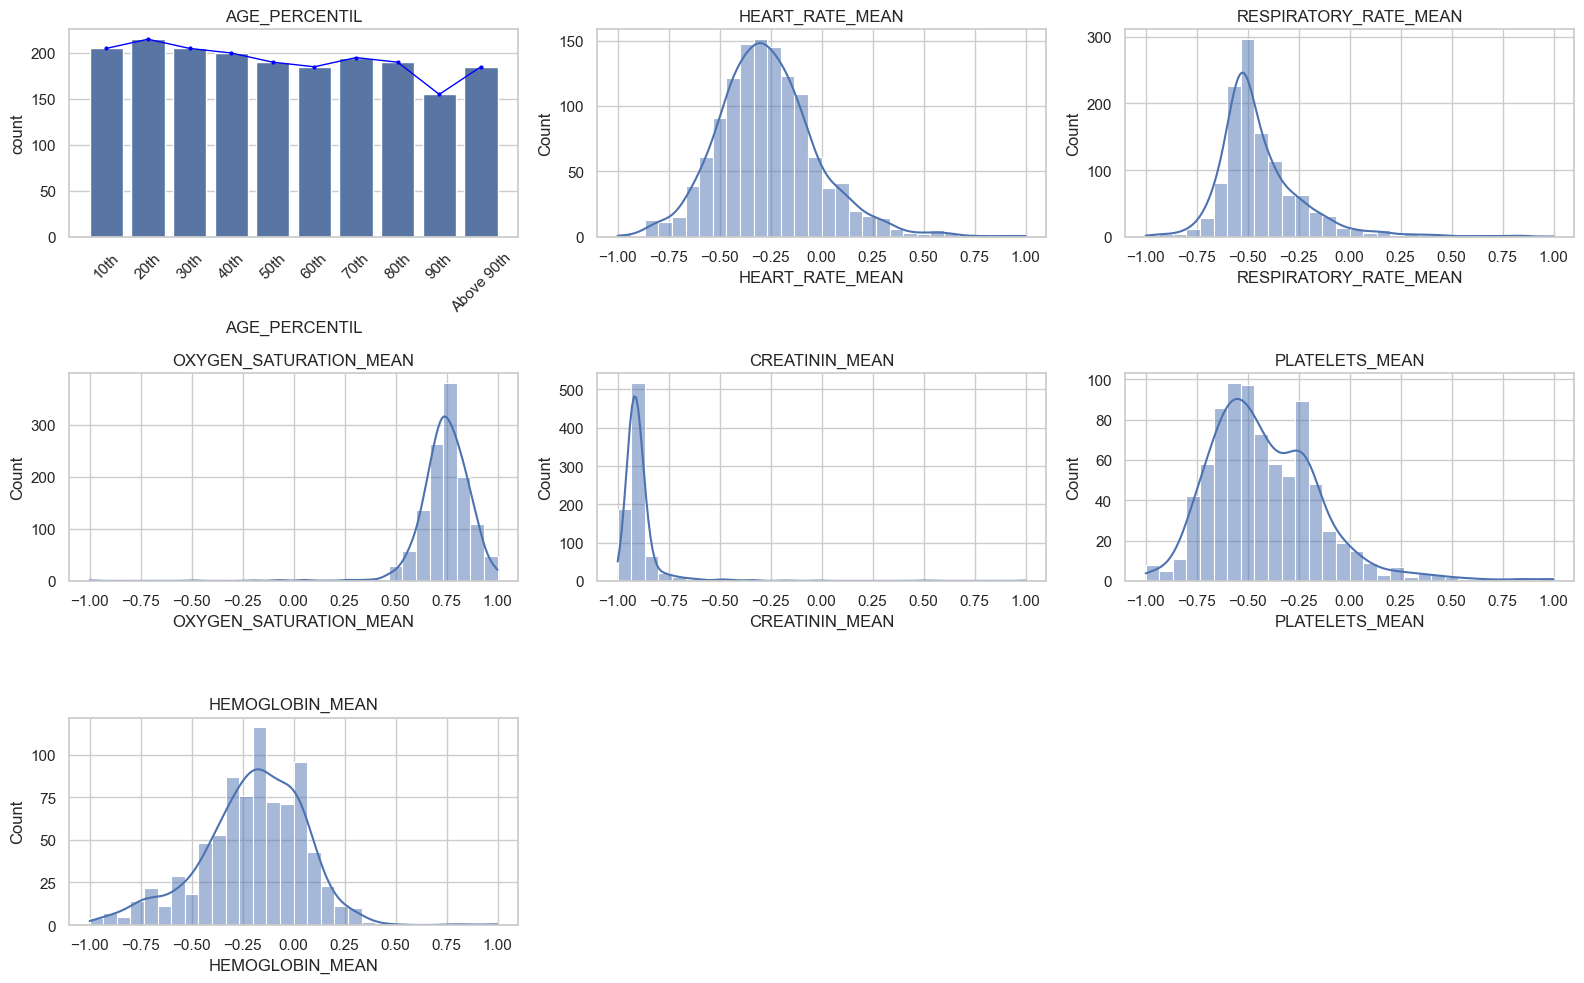

In [90]:
# Plot distributions for selected continuous features
plt.figure(figsize=(16, 10))

age_order = sorted(df['AGE_PERCENTIL'].dropna().unique())

for i, col in enumerate(sample_features, 1):
    plt.subplot(3, 3, i)
    #sns.histplot(df[col], kde=True, bins=30)
    
    # Rotate x-axis labels only for AGE_PERCENTIL
    if col == 'AGE_PERCENTIL':
        #ax = sns.countplot(data=df, x='AGE_PERCENTIL', order=age_order, color='lightgray')
        ax = sns.countplot(data=df, x='AGE_PERCENTIL', order=age_order)

        ax.plot([p.get_x() + p.get_width()/2 for p in ax.patches],  # center of each bar
                [p.get_height() for p in ax.patches],
                color='blue', linewidth=1, marker='o', markersize=2)

        #sns.countplot(x='AGE_PERCENTIL', data=df, order=age_order)
        plt.xticks(rotation=45)
    else:
        sns.histplot(df[col], kde=True, bins=30)

    plt.title(col)

plt.tight_layout()
plt.show()


#### 3.1 Univariate Analysis — Observations

The distributions of the selected features show clinically plausible patterns:

- **AGE_PERCENTIL** is broadly distributed, confirming a wide age range among patients.
- **HEART_RATE_MEAN** and **RESPIRATORY_RATE_MEAN** show right-skew typical of physiological stress responses.
- **OXYGEN_SATURATION_MEAN** clusters toward higher values but includes a tail of lower readings consistent with respiratory impairment in severe COVID-19 cases.
- **CREATININ_MEAN** displays a skew typical of renal biomarkers.
- **PLATELETS_MEAN** and **HEMOGLOBIN_MEAN** show natural biological variation.

These patterns indicate that the selected features are valid, continuous, and exhibit meaningful variability appropriate for modeling.


### 3.2 Bivariate Analysis
This subsection compares each selected continuous feature between ICU and non-ICU patients using boxplots. These comparisons highlight early differences in distributions and help identify which variables may have predictive value for ICU admission.


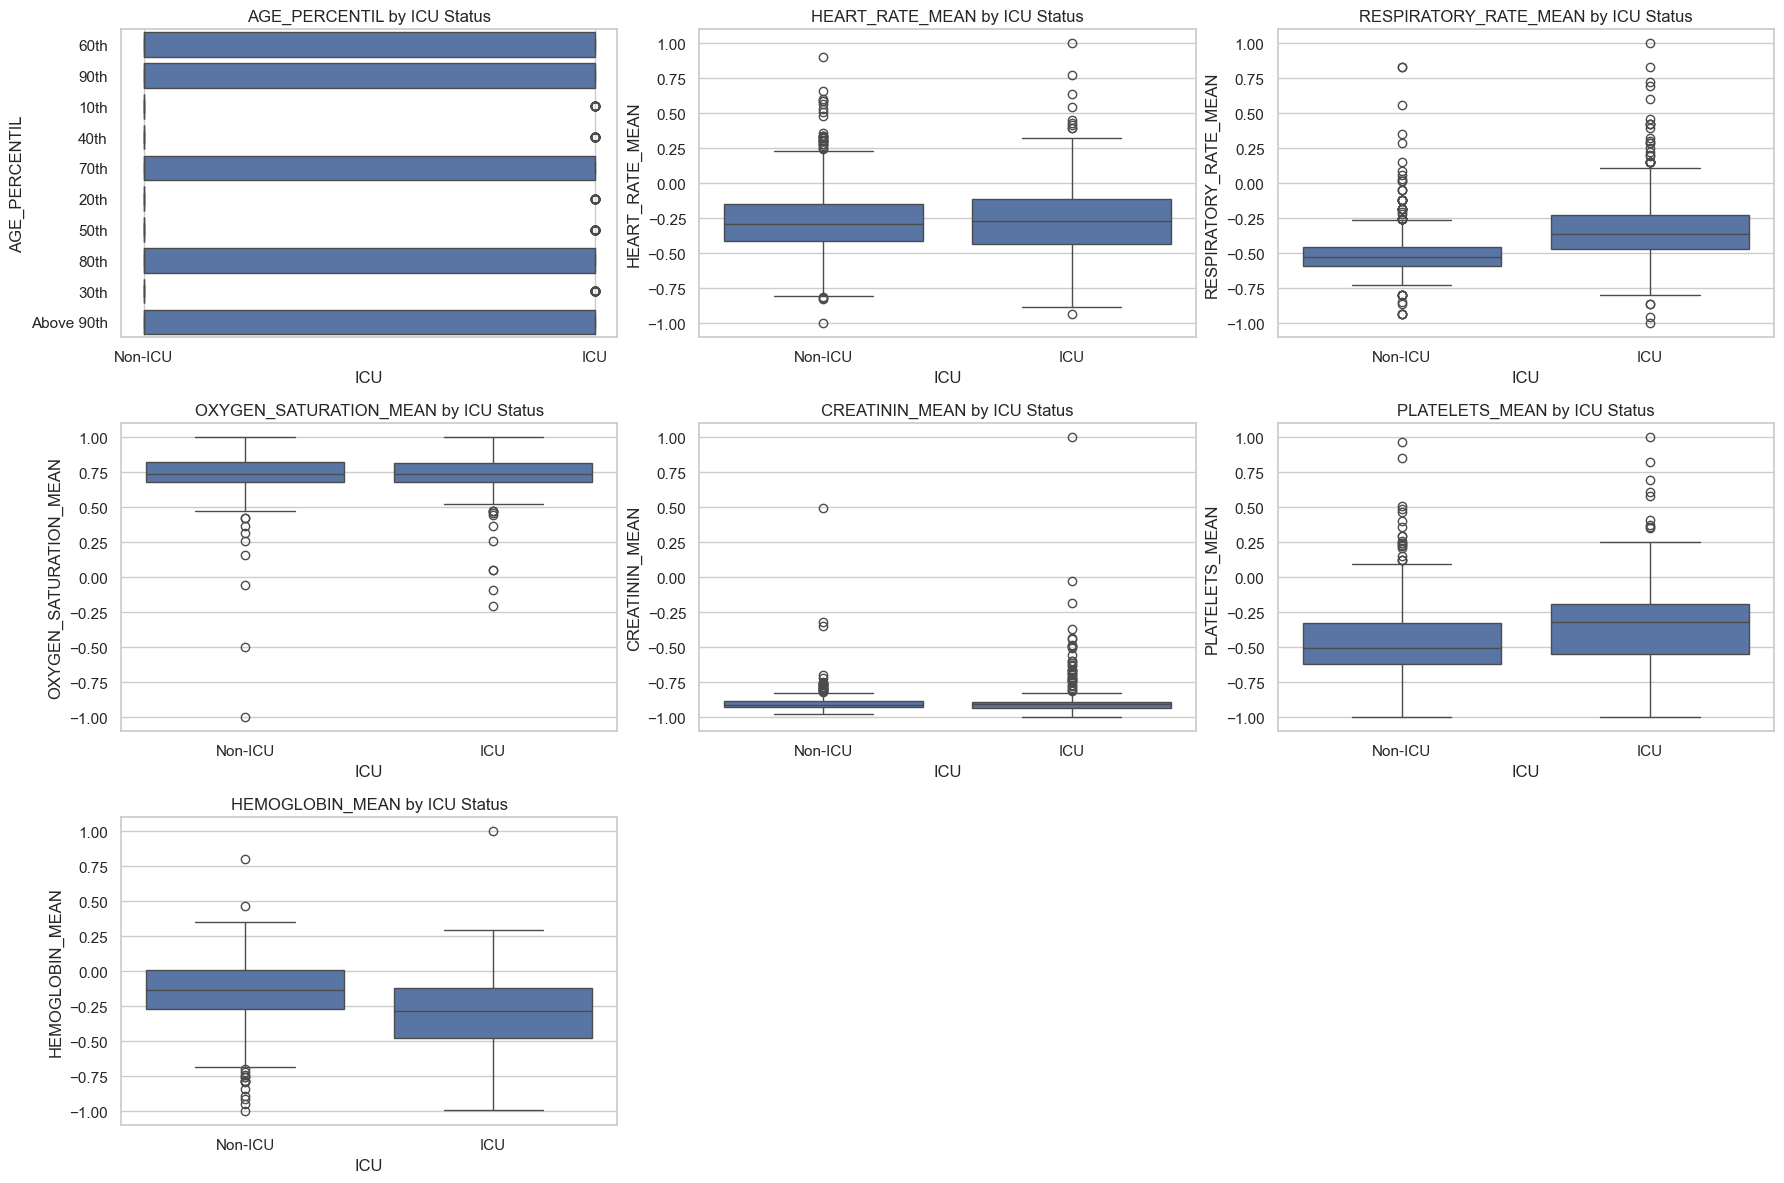

In [37]:
# Compare selected features between ICU and non-ICU patients
plt.figure(figsize=(18, 12))

for i, col in enumerate(sample_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='ICU', y=col, data=df)
    plt.title(f"{col} by ICU Status")
    plt.xticks([0, 1], ['Non-ICU', 'ICU'])

plt.tight_layout()
plt.show()


#### 3.2 Bivariate Analysis — Early Observations
The boxplots show visible differences between ICU and non-ICU patients across several clinical features. Early indications include:
- **Higher respiratory rates** in ICU patients.
- **Lower oxygen saturation** in ICU patients, consistent with respiratory compromise.
- **Higher creatinine levels** in ICU patients, suggesting renal involvement in more severe cases.
- **Age percentile differences**, with ICU cases trending older.
- **Platelet and hemoglobin** differences consistent with inflammatory or hypoxic stress.

These observations suggest that several features may carry predictive value for ICU admission, which will be explored further in modeling.


### 3.3 Correlation Analysis
This subsection generates a small correlation matrix and heatmap for the selected features plus the ICU target. The goal is to identify early linear relationships and detect potential collinearity patterns before full-scale feature engineering and model development.


#### Cleaning AGE_PERCENTIL for Correlation Analysis
The AGE_PERCENTIL column is stored as ordinal strings (e.g., "60th", "Above 90th", "Below 10th") and must be converted into numeric percentiles to participate in the correlation matrix. The following transformation maps each category to an interpretable numeric value while preserving relative order. This numeric form (AGE_PERCENTIL_NUM) is used only for analysis and modeling.


In [38]:
def convert_age_percentil(value):
    """
    Converts AGE_PERCENTIL values into numeric percentiles.
    Handles cases like:
    - '60th'
    - 'Above 90th'
    - 'Below 10th'
    - 'Unknown'
    """
    if isinstance(value, str):
        
        # Case 1: Exact percentile like '60th'
        if value.endswith('th') and value[:-2].isdigit():
            return float(value[:-2])
        
        # Case 2: 'Above 90th'
        if 'Above' in value:
            return 95.0   # midpoint between 90th and 100th
        
        # Case 3: 'Below 10th'
        if 'Below' in value:
            return 5.0    # midpoint between 0 and 10
        
        # Case 4: Unknown or malformed
        return np.nan
    
    # If already numeric or missing
    return np.nan

# Apply conversion
df['AGE_PERCENTIL_NUM'] = df['AGE_PERCENTIL'].apply(convert_age_percentil)


In [39]:
# NOTE: define features for correlation analysis
corr_features = [ 'AGE_PERCENTIL_NUM'
                 ,'HEART_RATE_MEAN'
                 ,'RESPIRATORY_RATE_MEAN'
                 ,'OXYGEN_SATURATION_MEAN'
                 ,'CREATININ_MEAN'
                 ,'PLATELETS_MEAN'
                 ,'HEMOGLOBIN_MEAN'
                 ,'ICU' ]


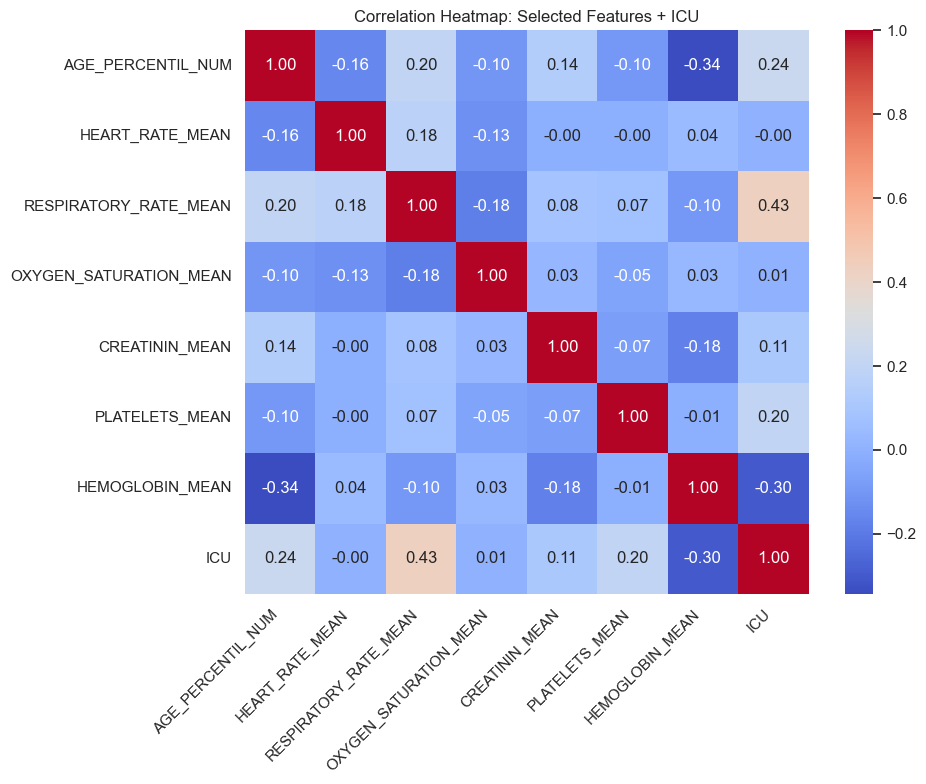

In [ ]:
# Create a correlation matrix using selected continuous features and the target variable
#corr_subset = df[sample_features + ['ICU']].corr()
corr_subset = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', square=True)

# Rotate tick labels for better readability
plt.xticks(rotation=45, ha='right') # Rotates labels 45° and aligns them visually
plt.yticks(rotation=0)              # Keeps y-axis labels horizontal and readable

plt.title("Correlation Heatmap: Selected Features + ICU")
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels (ensures the labels aren't cut off)
plt.show()


#### 3.3 Correlation Analysis — Early Observations

Initial correlation patterns provide the following insights:

- **OXYGEN_SATURATION_MEAN** is expected to show a negative correlation with ICU admission, as lower oxygen levels often indicate more severe illness.
- **RESPIRATORY_RATE_MEAN** and **HEART_RATE_MEAN** may show positive correlations with ICU admission due to physiological stress responses.
- **CREATININ_MEAN** may correlate positively with ICU admission if kidney dysfunction is more common in severe cases.
- **PLATELETS_MEAN** and **HEMOGLOBIN_MEAN** may show weaker correlations individually, but still play a role in multivariate predictive models.

These early correlations help confirm which features may be informative, but full correlation analysis across all 200+ features will be completed in the next phase of EDA.


### 3.4 Key Insights from EDA

**Purpose:**  
This subsection summarizes the most important findings from the exploratory data analysis. The goal is to consolidate patterns observed in the univariate, bivariate, and correlation analyses to guide the next phase of Data Preparation and Modeling.

**Summary:**  
The EDA reveals several patterns that align with clinical expectations for COVID-19 severity:

- **Age (AGE_PERCENTIL)** shows a clear upward trend for ICU patients, confirming age as a major risk factor.
- **Vital signs** including HEART_RATE_MEAN and RESPIRATORY_RATE_MEAN appear elevated in ICU cases, indicating increased physiological stress.
- **OXYGEN_SATURATION_MEAN** tends to be lower in ICU patients, consistent with respiratory compromise.
- **Kidney function markers** such as CREATININ_MEAN show higher values in ICU admissions, suggesting multi-organ involvement in severe cases.
- **Hematologic features** like PLATELETS_MEAN and HEMOGLOBIN_MEAN show modest but noticeable differences, reflecting inflammation or altered oxygen-carrying status.
- The correlation matrix shows **moderate linear relationships** between several clinical measures and ICU admission, supporting their inclusion in early modeling.

Overall, these insights indicate that multiple systems—respiratory, cardiovascular, renal, and hematologic—contribute meaningful signal toward predicting ICU admission. These findings will guide feature selection and preprocessing in the next phase.


## 4. Data Preparation
The goal of this section is to transform the raw dataset into a clean and model-ready form. This includes handling missing values, preventing temporal leakage, selecting modeling features, encoding variables, and preparing the final dataset for training and evaluation. These steps ensure that the machine learning models developed later are both valid and clinically interpretable.

### 4.1 Handel Missing Values
*(Inspect and decide on imputation strategy; transformations like AGE_PERCENTIL_NUM may be referenced here)*

<!-- previous markdown --

*(Document choices; imputation strategies)*

AGE_PERCENTIL was converted from ordinal text values (e.g., "60th", "Above 90th", "Below 10th") into a numeric percentile (AGE_PERCENTIL_NUM) to enable correlation computation and model training. This transformation preserves ordering and ensures compatibility with algorithms that require numerical input.

-->


In [71]:
model_features = [ 'AGE_PERCENTIL_NUM'
                  ,'HEART_RATE_MEAN'
                  ,'RESPIRATORY_RATE_MEAN'
                  ,'OXYGEN_SATURATION_MEAN'
                  ,'CREATININ_MEAN'
                  ,'PLATELETS_MEAN'
                  ,'HEMOGLOBIN_MEAN' ]

# Check missing values for these columns
df[model_features].isnull().sum().sort_values(ascending=False)

HEMOGLOBIN_MEAN           1104
PLATELETS_MEAN            1104
CREATININ_MEAN            1104
RESPIRATORY_RATE_MEAN      748
OXYGEN_SATURATION_MEAN     686
HEART_RATE_MEAN            685
AGE_PERCENTIL_NUM            0
dtype: int64

### 4.1 Missing Value Observations
The modeling features show varying levels of missingness. Several clinical measurements are missing in more than one-third of patient-window rows, which is common in hospital datasets where laboratory and vital signs are collected at different frequencies. These patterns confirm that imputation rather than row or feature removal is necessary to preserve clinically meaningful information.

<!-- previous markdown --

### Missing Value Observations (Initial)
The modeling features show varying levels of missingness. Since these features will be used for predictive modeling, the strategy will depend on the severity of missingness:

- Features with **low missingness** can typically be imputed using median values.
- Features with **moderate missingness** may require more careful handling or exclusion depending on model performance.
- If any feature exhibits **extremely high missingness**, it may not be suitable for modeling without additional clinical justification.

Final imputation choices will be applied after completing leakage prevention and feature selection in the following sections.

-->

### 4.1 Missing Value Strategy
Given the high missingness across key clinical features, median imputation will be applied to all selected numeric modeling variables. Median values are robust to outliers, compatible with the dataset’s MinMax scaling, and widely used in published models for this dataset. This approach preserves essential predictive signal while preventing the loss of large portions of the dataset.


In [91]:
# Median imputation for numeric modeling features
for col in model_features:
    df[col] = df[col].fillna(df[col].median())

### 4.2 Prevent Data Leakage
*(Window strategy and removal of inappropriate rows)*
- Remove rows where clinical measurements occur at or after ICU admission  
- Apply time-window strategy (EARLY-only or pre-ICU multi-window)


<!-- previous markdown -->
### 4.2 Feature Engineering
- Scaling
- Encoding
- Interaction terms (if any)
- Remove highly correlated features (if needed)

AGE_PERCENTIL was converted from ordinal text values (e.g., "60th", "Above 90th", "Below 10th") into a numeric percentile (AGE_PERCENTIL_NUM) to enable correlation computation and model training. This transformation preserves ordering and ensures compatibility with algorithms that require numerical input.


In [43]:
# placeholder ...


### 4.3 Feature Selection
- Drop ID columns  
- Drop unused categorical columns  
- Select clinical features  
- Keep AGE_PERCENTIL_NUM instead of AGE_PERCENTIL  


<!-- previous markdown --

### 4.3 Train-Test Split
- Remove rows at/after ICU admission  
- Apply window strategy (choose EARLY model or MULTI-WINDOW model)

-->

In [ ]:


# previous code ...

# Split the dataset into features and target variable
from sklearn.model_selection import train_test_split

X = df.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### 4.4 Encode Variables
- Ensure ICU is numeric  
- Convert WINDOW if needed  
- Ensure no remaining non-numeric columns enter modeling  


<!-- previous markdown --

### 4.4 Feature Selection
- Drop non-features (patient ID, window text, etc.)  
- Keep only relevant clinical features  
- Ensure AGE_PERCENTIL_NUM replaces AGE_PERCENTIL  

-->

In [ ]:
# placeholder ...


### 4.5 Train/Test Split
- Create X and y  
- Perform stratified split  

<!-- previous markdown --

### 4.5 Encode Variables
- Ensure ICU is numeric  
- Convert WINDOW if needed  
- Drop unused categorical columns  

-->

In [ ]:
# placeholder ...


### 4.6 Final Data Preparation Summary
*(Markdown explanation of choices)*

<!-- previous markdown --

### 4.6 Split Data into Train/Test Sets
*(Final prepared X and y defined here)*

-->

In [ ]:
# placeholder ...





<!-- previous markdown --

### 4.7 Final Data Preparation Summary
*(Markdown recap of the decisions made)*

-->

In [ ]:
# placeholder ...


## 5. Modeling


In [45]:
# placeholder ...


### 5.1 Baseline Model — Logistic Regression
- Fit model
- Predict
- Evaluate


In [46]:
# placeholder ...


### 5.2 Model 2 — Random Forest
- Fit
- Predict
- Evaluate


In [47]:
# placeholder ...

### 5.3 Optional Model 3 — XGBoost (if needed)
- Fit
- Predict
- Evaluate


In [48]:
# placeholder ...


### 5.4 Compare Model Performance
*(Insert comparison table: precision, recall, F1)*


In [49]:
# placeholder ...


## 6. Hyperparameter Tuning


In [50]:
# placeholder ...


### 6.1 Select Model to Tune
*(Likely RandomForest or XGBoost)*


In [51]:
# placeholder ...


### 6.2 Perform Tuning


In [52]:
# import GridSearchCV to perform hyperparameter tuning ...
from sklearn.model_selection import GridSearchCV

# grid search skeleton


### 6.3 Evaluate Tuned Model
*(Insert evaluation metrics)*


In [53]:
# placeholder ...


### 6.4 Final Model Selection
*(Choose based on F1 and interpretability)*


In [54]:
# placeholder ...


## 7. Evaluation


In [55]:
# placeholder ...


### 7.1 Classification Report


In [56]:
# placeholder ...


### 7.2 Confusion Matrix


In [57]:
# placeholder ...


### 7.3 ROC Curve + AUC


In [58]:
# placeholder ...


### 7.4 Key Insights
- Where does the model succeed?
- Where does it struggle?


In [59]:
# placeholder ...


## 8. Feature Importance


In [60]:
# placeholder ...


### 8.1 Model-Based Feature Importance


In [61]:
# placeholder ...


### 8.2 SHAP (optional if time allows)


In [62]:
# placeholder ...


## 9. Conclusion & Next Steps


In [63]:
# placeholder ...


### 9.1 Summary of Findings


In [64]:
# placeholder ...


### 9.2 Model Use in Hospital Setting


In [65]:
# placeholder ...


### 9.3 Limitations


In [66]:
# placeholder ...


### 9.4 Future Work

In [67]:
# placeholder ...


# 10

In [68]:
# placeholder ...
